# # Model Selection using RFE(Recursive Feature Elimination)

As we have seen that it took so long followed by so many processes to come up with a quality model..
But we can do all these things in an automatic way.

In [1]:
import numpy as np
import pandas as pd

In [4]:
df =pd.read_csv('Housing.csv')

In [5]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [6]:
df['mainroad']=df['mainroad'].map({'yes':1,'no':0})
df['guestroom']=df['guestroom'].map({'yes':1,'no':0})
df['basement']=df['basement'].map({'yes':1,'no':0})
df['hotwaterheating']=df['hotwaterheating'].map({'yes':1,'no':0})
df['airconditioning']=df['airconditioning'].map({'yes':1,'no':0})
df['prefarea']=df['prefarea'].map({'yes':1,'no':0})

In [7]:
#create a dummy variable to store the values of column in a way which we can easily process and dropping the first column
status=pd.get_dummies(df['furnishingstatus'],drop_first=True)

In [8]:
df=pd.concat([df,status],axis=1)

In [9]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [10]:
df.drop(["furnishingstatus"],axis=1,inplace=True)

In [11]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


# Creating new variables

In [12]:
df["areaperbedroom"]=df["area"]/df["bedrooms"]
df["bbratio"]=df["bathrooms"]/df["bedrooms"]

# Rescaling the features

It is extremely important to rescale the values as to make the values comparable.

In [13]:
def normalize(x):
    return((x-np.min(x))/(max(x)-min(x)))

df=df.apply(normalize) #applying normalize to all columns

# Splitting data

In [15]:
X= df[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaperbedroom', 'bbratio']]

Y=df['price']

In [16]:
from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,train_size=0.7,test_size=0.3,random_state=100)

# RFE

In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [19]:
lm=LinearRegression()
rfe=RFE(lm,9) #here we are passing our linear regression object along with secong argument 9 which means that we need only 9 best columns out of our data set to be used for prediction
rfe=rfe.fit(x_train,y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True False  True  True  True False False  True  True False  True False
 False  True  True]
[1 3 1 1 1 4 6 1 1 2 1 7 5 1 1]


-----> The above boolean true values tells that these 9 values are most suitable for model building. It rejects all the false values.

In [21]:
col=x_train.columns[rfe.support_]
x_train_rfe=x_train[col]

In [24]:
# Adding a contant variable
import statsmodels.api as sm
x_train_rfe=sm.add_constant(x_train_rfe)


In [25]:
lm=sm.OLS(y_train,x_train_rfe).fit()

In [26]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     80.14
Date:                Tue, 23 Jul 2019   Prob (F-statistic):           1.88e-81
Time:                        02:26:10   Log-Likelihood:                 369.54
No. Observations:                 381   AIC:                            -719.1
Df Residuals:                     371   BIC:                            -679.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0139      0.021     

We can observe that our R-squared and Adj. R-squared values are quite good but we can further compare with VIF values.

# VIF 

In [27]:
def vif_cal(input_data,dependent_col):
    vif_df=pd.DataFrame(columns=['var','vif'])
    x_vars=input_data.drop([dependent_col],axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]]
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared
        vif=round(1/(1-rsq),2)
        vif_df.loc[i]=[xvar_names[i],vif]
    return vif_df.sort_values(by='vif',axis=0,ascending=False,inplace=False)

In [29]:
#calculating vif value
vif_cal(input_data=df.drop(["bedrooms","guestroom","basement","parking","semi-furnished","unfurnished"],axis=1),dependent_col='price')

,var,vif
7,areaperbedroom,47.13
0,area,36.10
8,bbratio,21.15
1,bathrooms,8.85
3,mainroad,6.61
2,stories,2.44
5,airconditioning,1.72
6,prefarea,1.43
4,hotwaterheating,1.07


We can use VIF and rfe at th same time for model building.

# Make Predictions

Now let's use our model to make predictions

In [30]:
x_test_rfe=x_test[col]

x_test_rfe=sm.add_constant(x_test_rfe)

y_pred=lm.predict(x_test_rfe)

# Model Evaluation

Text(0,0.5,'Sales')

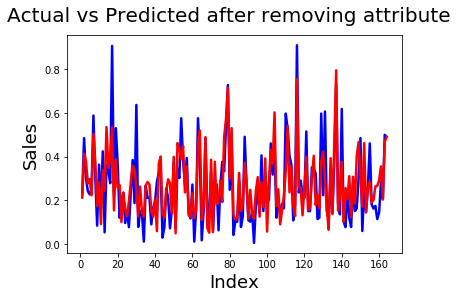

In [31]:
import matplotlib.pyplot as plt
c= [i for i in range(1,165,1)] # generating indexes
fig =plt.figure()
plt.plot(c, y_test, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c, y_pred, color="red", linewidth=2.5, linestyle="-")
fig.suptitle("Actual vs Predicted after removing attribute", fontsize=20)
plt.xlabel('Index',fontsize=18)
plt.ylabel('Sales',fontsize=18)

# Accuracy of your model
